<a href="https://colab.research.google.com/github/denniesbor/Module-3/blob/development/Final_Notebook_Foodie_App_with_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><font color='red'>The foodies app</font><center>
> <center><h3>What are we having for supper?</h3></center>

<center><img src=https://miro.medium.com/max/1400/1*9AXti3Lgxm7vi9BLIRDc1A.png><center>


**Team members:** Rhodasi, Dennies, Margaux

**Tutor:** Emmanuel

**Aim of the app**

The aim of this project is to offer an online app for users to find the best restaurant that fits their cravings. 
The user provides an input of any kind such as "I feel like some spicy chicken" and 5 top rated restaurants will be suggested to him/her.



**Implementation**

We have implemented a series of natural language and sentiment classifiers to (1) analyse the user input, (2) to analyse the reviews from the yelp dataset and try to improve the star rating system

**Organisation of the notebook**

### EDA


> We used the yelp review dataset as the core of our database. this first part is exploring the dataset (2 files) and prepare it (subset) to be used in our app
> 1.   The business file
> 2.   The reviews file

### Food Classification Models
> This first bloc consists of models that analyse the user input. First, we classify the user input into 3 food categories (cuisine, meal, diet). Next, we expand the vocubulary to include synonyms and finaly, we apply a semantic search to facilitate and improve the matching with the yelp database categories. The meal type classifer was trained on [american menus](http://menus.nypl.org/) and diet and cuisine classifier on [yummly](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/W0OB30) recipes.
> 1.  Meal type classifier
> 2.  Cuisine type classifier 
> 3.  Diet type classifier 
> 4.  Semantic search
>       *   [Latent Semantic Indexing](https://medium.com/betacom/latent-semantic-indexing-in-python-85880414b4de)
>       *   [Term-frequency-inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

### Processing User Input

> We processed the user input by applying tokenisation, lematisation and stop-word removal. This processed input is fed into the above mentioned food type classifiers and the output categories are matched using the semantic search to the yelp database

### Sentiment Analyses Model
> We created a training set and computed a sentiment score for that training set. The training set is also from yelp but different from the one in our database. The sentiment score was created to improve or complement the star system. It is based on polarity, proportion of positive/negative words and the star for that specific review.

> 1.   Create a training dataset and sentiment score
>          1.1. Extract a balanced subset
>          1.2. Stemming and Lemmatization of the reviews
>          1.3. Calculate polarity and subjectivity
>          1.4. Calculate an index based on the proportion of positive and negative words
>          1.5. Combine the 3 criteria Polarity, star rating and proportion of positive/negative words
>          1.6. Classify into 20 categories from 1 (worst) to 20 (best)
>          1.7. Few EDA checks on the training dataset and the sentiment score we have created
> 2.    Training the sentiment model
> 3.    Model prediction on the yelp dataset

> the output of this model is a new feature with a sentiment score that we are uwing together with the average star rating (for each restaurant) to rank the restaurants. The top 5 restaurants are then selected and suggested to the user



**The app**

The project consists of two parts, the frontend and the backend. Frontend is designed with ReactJS, HTML, and CSS. ReactJS allows for DOM manipulation and interactivity. 
The default home page is a simple form that takes a user input which is then *JSONified and sent as a POST request payload to the backend. Frontend renders the returned user data, and loads the Mapbox API showing the Restaurant location.

The role of the backend is to make the app accessible online, run the models on the user input and serves the restaurant data as a response. The server is RESTful, and is powered by Django in a AWS Ubuntu ec2. The requests data is received by the api endpoint, and forwarded to a food recommendation pipeline consisting of pretrained model weights. 
The output from the models which are sorted by relevance are used to query the database to retrieve some of it's components such as star ratings, sentiment scores, etc. 

Django Rest Framework serializes the data as JSON fields and returns to the user. In the background, we have a mysql server as a project database and consists of meal categories, recipes, reviews, and restaurant businesses schemas.

The Django Queryset API handles database queries, and is efficient as it is lazy(Runs the query only when it's called). ReactJS triggers a side effect that queries the meals table whenever a user makes an input, providing the suggestions. 
Some of the queries are similar, and the models, are cached in memory. Redis, and Django Redis allows memory caching and therefore limits the amount of similar requests hitting the database. This speeds up server response. The Nginx Reverse Proxy server is used to make the app accessible via HTTP/HTTPS.

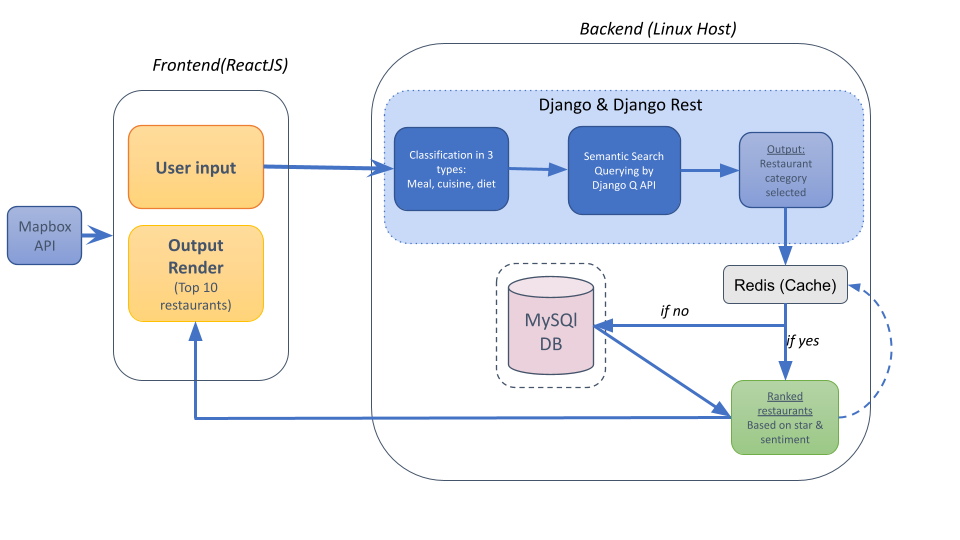


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spacy
!pip install spacy-langdetect
!python -m spacy download en
!python -m spacy download en_core_web_sm
!pip install en_core_web_sm
!pip install spacytextblob

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0-py3-none-any.whl (13.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 13.9 MB 1.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import json
import re

import pickle
import string
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap,MarkerCluster
import folium

#modules and libraries for training
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report, confusion_matrix


import spacy
from spacy_langdetect import LanguageDetector



<center><img src="https://cdn.educba.com/academy/wp-content/uploads/2020/01/exploratory-data-analysis.jpg.webp" width=700/></center>


We are going to use the yelp dataset. This dataset is composed of 2 datasets. 

1.   The Business file: This first file has details on the restaurant itself such as opening hours, business categories, geolocalisation, name, a business_id, average star rating, etc... 
2.   The Reviews file: this file is much larger and has all the individual reviews and star rating for that review. 

Note that both files have the "business_id" which is common to both datafile and being used when matching is necessary

We describe below these two datasets with a some EDA.

## **1) Business File**

In [ ]:
#load dataset 
path_to_business = '/content/drive/MyDrive/DSI module3/Data/yelp_academic_dataset_business.json.zip'   # path to change if needed
business=pd.read_json(path_to_business, lines=True)

business.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None


In [ ]:
# Select only restaurants from all the businesses in the dataset and the once that are still open
business['restaurant']= business.categories.str.contains(pat='Restaurants|Restaurant|food',flags=re.IGNORECASE, regex=True)
print(business[business.restaurant == True].shape)
resto = business[(business.restaurant == True) & (business.is_open == 1)]
print(resto.shape)
resto.head()

(64629, 15)
(44594, 15)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurant
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",True
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",True
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",True


In [ ]:
# checking if the star column has missing data
resto.stars.isnull().sum()

0

No invalid star rating

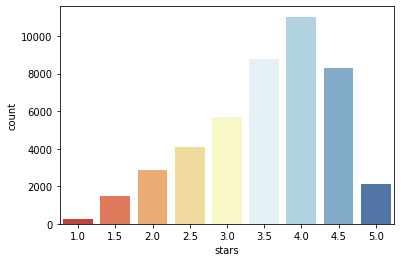

In [ ]:
# Distribution of the star rating of each restaurant
sns.countplot(x="stars",
              data=resto,
              palette="RdYlBu",
              linewidth=3)
plt.show()

We can see here that the dataset is biaised with low representation of restaurant with low or high star ratings. We investigated several database and it seems to be a natural type of distribution amongst restaurants reviews database

In [ ]:
print('Number of restaurant in the dataset buisness')
resto.business_id.unique().shape

Number of restaurant in the dataset buisness


(44594,)

So there are no duplicates here as the number of rows corresponds to number of restaurants

In [ ]:
allrestotype = np.array(' '.join([i for i in resto.categories]).split(','))
print('this is the number of categories we have in our dataset: ', np.shape(allrestotype))

this is the number of categories we have in our dataset:  (166891,)


In [ ]:
# count the frequency of each word
from collections import Counter
def words_occurence(txt):
  occurence=[]
  word=[]
  for wordi, counti in Counter(txt).items():
       #print(f"[{count}] {word}")
       occurence.append(counti)
       word.append(wordi)
  freq = pd.DataFrame({'occurence': occurence, 'word':word})
  return freq

type_resto = words_occurence(allrestotype)
type_resto.head()

,occurence,word
0,1,Restaurants
1,10763,Food
2,213,Bubble Tea
3,2568,Coffee & Tea
4,2,Bakeries Brewpubs


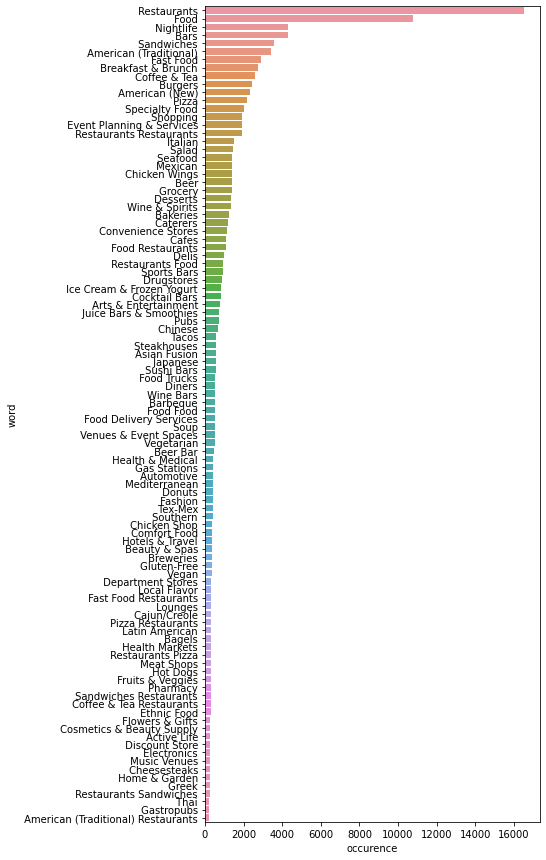

In [ ]:
# plot the first 50 more abundant categories
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x="occurence", y="word", data=type_resto.sort_values(by='occurence', ascending=False).iloc[:100])
plt.show()

We could do a bit of cleaning here in the category type (e.g. remove 'food', 'restaurants', 'restaurants restaurants') but at the same time, we will only use it to find the type of restaurant the user wants so not strickly needed now

In [ ]:
n = type_resto[type_resto.occurence == 1].sum()[0]
np = round((n * 100 / int(resto.shape[0])),2)
print('the number of restaurant category that appear only once {}, which represent {} % of our dataset'.format(n, np))

the number of restaurant category that appear only once 5551, which represent 12.45 % of our dataset


### **Location of the restaurants**

In [ ]:
# checking the coordinates to see where the restaurants are located
print(resto.latitude.min(), resto.latitude.max())
print(resto.longitude.min(), resto.longitude.max())
print(len(resto.latitude.unique())) # only few that don't have lat/lon
print(len(resto.city.unique()))  # number of cities 

27.5644572387 53.6791969
-120.083748 -74.661348
43008
919


In [ ]:
# # use an interactive maps to show the restaurant locations with folium
resto['latitude'] = resto['latitude'].astype(float).fillna(0)
resto['longitude'] = resto['longitude'].astype(float).fillna(0)

m1=folium.Map(width=1000,height=600, location = (37,-95),
              max_zoom=12,min_zoom=2,zoom_start=2,
              tiles='open street map')

locations = resto[['latitude','longitude']].to_numpy()  #[0:10]
cluster = MarkerCluster(locations=locations).add_to(m1)

m1

# note that this is meant to be an interactive map but it is too large for GitHub.
# Please refer to the colab version of the notebook if you want to use the interactive maps 

<<img src="https://github.com/denniesbor/Module-3/raw/assets/img-notebooks/Map1_Foodies.jpg" >


## **2) The Reviews File**

In [ ]:
path_to_reviews = r'/content/drive/MyDrive/DSI module3/Data/yelp_academic_dataset_review.json'  # to change if needed

# loading in chunk because of its size
reviews = None
with pd.read_json(path_to_reviews, lines=True, chunksize=5000) as reader:
    reader
    for chunk in reader:
        if reviews is None:
            reviews = chunk
        else:
            reviews = reviews.append(chunk)


print(reviews.shape)

the dataframe is (6990280, 9)

In [ ]:
# checking again that all the reviews have a valid star rating
reviews.stars.isnull().sum()

0

All reviews have a valid star rating

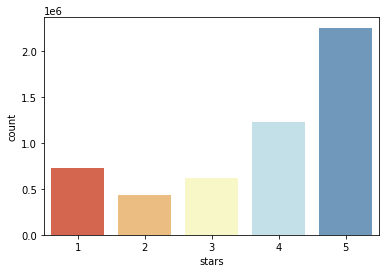

In [ ]:
sns.countplot(x="stars",
              data=reviews,
              palette="RdYlBu",
              linewidth=3)
plt.show()

This is the number of stars for all the reviews so it is normal it doesn't look like the previous star rating plot which was the average star rating for each restaurant

**Because we want a fast app and time constraints (longer time needed to train model), we have limited our dataset to the restaurants in one region: 
between -80 and -70 in longitude which correspond to 4 states in the USA: PA, NJ, DE, NV**

With more time and resources, we would have expand this to more restaurants in other regions and offer the user to choose a location (with a perimeter) on the app. 

In [ ]:
# we are here selecting based on the longitude
resto_NW = resto[(resto.longitude>-80) & (resto.longitude<-70)]
print(resto_NW.state.unique())
print(resto_NW.shape)
resto_NW.head()

['PA' 'NJ' 'DE' 'NV']
(14106, 15)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurant
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",True
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",True
33,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,PA,19003,40.006707,-75.289671,3.5,109,1,"{'RestaurantsGoodForGroups': 'True', 'WiFi': '...","Pizza, Restaurants","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",True


We have at the end restaurants from 3 states in the USA: Pennsylvania (PA), New Jersey (NJ) and Delaware (DE). 

*NB: Nevada (NV) is an error in the state column, see below it should have been NJ*

In [ ]:
resto_NW[resto_NW.state == 'NV']  # 1 error in the state initial below

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurant
75677,r1p7RAMzCV_6NPF0dNoR3g,Cater 2 U,2901 Marne Hwy,Mount Laurel,NV,08054,39.980331,-74.858983,2.5,7,1,"{'RestaurantsDelivery': 'True', 'NoiseLevel': ...","Event Planning & Services, Caterers, Venues & ...",None,True


In [ ]:
# # Checking the location of the new dataset we will using later on
m1=folium.Map(width=1000,height=600, location = (37,-95),
              max_zoom=12,min_zoom=2,zoom_start=2,
              tiles='open street map')

locations = resto_NW[['latitude','longitude']].to_numpy()
cluster = MarkerCluster(locations=locations).add_to(m1)

m1

# note that this is meant to be an interactive map but it is too large for GitHub.
# Please refer to the colab version of the notebook if you want to use the interactive maps 

<img src="https://github.com/denniesbor/Module-3/raw/assets/img-notebooks/Map2_Foodies.jpg" >

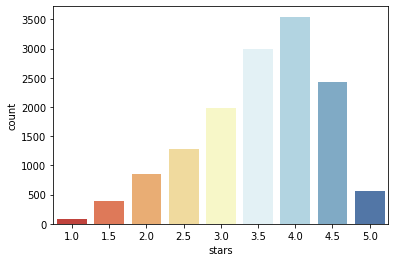

In [ ]:
# the star distribution within that restricted dataset
sns.countplot(x="stars",
              data=resto_NW,
              palette="RdYlBu",
              linewidth=3)
plt.show()

It is a bit biaised towards 4 stars but this looks similar to the distributions of all the restaurants within the database

In [ ]:
# select a subset of the review dataset to use for the app
reviews_NW = reviews[(reviews['business_id'].isin(resto_NW.business_id))]
print(reviews_NW.shape)
reviews_NW.head()

(1102090, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25
19,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27
26,G_5UczbCBJriUAbxz3J7Tw,clWLI5OZP2ad25ugMVI8gg,x4XdNhp0Xn8lOivzc77J-g,5,0,0,0,Best thai food in the area. Everything was au...,2013-08-15 15:27:51


In [ ]:
# to use in case of memory issues although it will be needed at the start of the sentiment analyses model
# import gc
# del reviews
# gc.collect()

<img src="https://ahchealthenewscdn.azureedge.net/wp-content/uploads/2013/07/Gut-reaction-Can-your-diet-affect-the-way-you-think.jpg">

# <font color='red'>**Food Classification Models**</font>

The first step in the app is for the user input to be analysed and categorised. Food categories are determined using three text classification models:

1.   Meal type classifier: appetiser, entree, breakfast etc
2.   Cuisine type classifier: italian, asian, etc
3.   Diet type classifier: vegeterian or non-vegeterian

All the models are Sklearn logistic regression models trained for text classification on two datasets. Logistic regressors were chosen for simplicity of use, shorter time needed for training and they are generally reported to be robust on simple classification tasks. An ideal situation would be to explore more complex models including neural networks. 

### **Pre-processing Helper**
> This applies a simple natural language processing pipeline to our text.

In [ ]:
#Tokenization and pre-processing for nlp
punct = string.punctuation
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("spacytextblob")
stopwords = list(STOP_WORDS)


def text_data_cleaning(sentence):
    '''
    
    Takes a text and pre-processes it for downstream nlp
    input: single document
    output: returns a tokenised document
    
    '''
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens

## **1) Meal type classifier**
> Training dataset used: [historical american menus]() 1980-

In [ ]:
# load the america menu dataset
american = pd.read_csv("/work/Foodie data/historicalamerican/dohmh-menustat-historical-1.csv")
AmX = american['Item_Description'] #feature is description of menu item
target = american['Food_Category'] 
american['Food_Category'].value_counts()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3229: DtypeWarning: Columns (9,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Beverages                 23396
Toppings & Ingredients    10153
Entrees                    7579
Sandwiches                 6391
Appetizers & Sides         4123
Pizza                      3373
Desserts                   3016
Baked Goods                1908
Salads                     1807
Burgers                    1558
Soup                       1175
Fried Potatoes              740
Name: Food_Category, dtype: int64

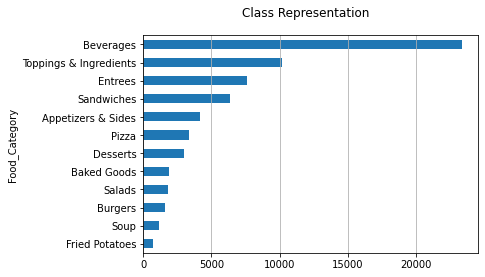

In [ ]:
#Visualise the distribution of our target
fig, ax = plt.subplots()
fig.suptitle("Class Representation", fontsize=12)
american['Food_Category'].reset_index().groupby("Food_Category").count().sort_values(by= 
        "index").plot(kind="barh", legend=False, 
         ax=ax).grid(axis='x')
plt.show()

#### Model Training


In [ ]:
# create a mapping of unique label texts to unique integers
labelencoderCourse = LabelEncoder()
ym = labelencoderCourse.fit_transform(target)

#pre-processing
tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)

# Logistic regression classifier
course =LogisticRegression(solver='saga')
Xm=AmX #features
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size = 0.2, random_state = 42)
Xm_train.shape,Xm.shape, ym_train.shape
course = Pipeline([('tfidf', tfidf), ('course', course)])
course.fit(Xm_train, ym_train)
filename = 'meal_model.sav' #save model for use on backend of foodie_app
pickle. dump(course, open(filename, 'wb'))

In [ ]:
#Check the performance of the classifier
#course= pickle.load(open('/kaggle/working/meal_model.sav', 'rb')) #load  saved model
ym_pred=course.predict(Xm_test)
print(classification_report(ym_test, ym_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       851
           1       0.92      0.87      0.89       379
           2       0.99      1.00      0.99      4678
           3       0.92      0.92      0.92       321
           4       0.96      0.96      0.96       581
           5       0.84      0.91      0.87      1484
           6       0.82      0.70      0.75       147
           7       0.96      0.95      0.96       683
           8       0.90      0.86      0.88       409
           9       0.91      0.93      0.92      1220
          10       0.96      0.92      0.94       251
          11       0.88      0.85      0.87      2040

    accuracy                           0.93     13044
   macro avg       0.91      0.89      0.90     13044
weighted avg       0.93      0.93      0.93     13044



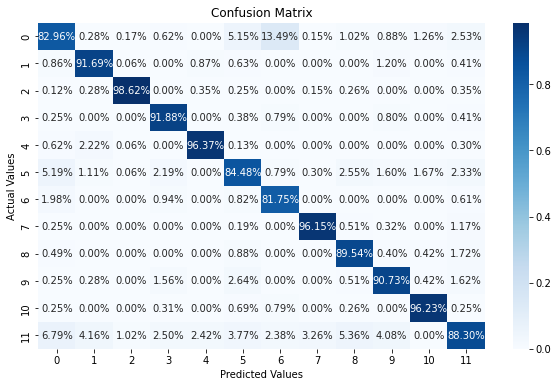

In [ ]:
#Plotting the confusion matrix
cm_meal = confusion_matrix(ym_test, ym_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df1 = pd.DataFrame(cm_meal)

plt.figure(figsize=(10,6))
sns.heatmap(cm_df1/np.sum(cm_df1), annot=True, cmap='Blues', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


## **2) Cuisine type classifier**

In [ ]:
### Data is recipes from Yummly.com ###
#######################################
recipes=pd.read_json('/work/Foodie data/recipes/train.json')
recipes.head(1)

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."


In [ ]:
#Remove  nested list
recipes['ingredients_mod'] = [' '.join([re.sub('[^A-Za-z]', ' ,', line) for line in lists]).strip() for lists in recipes['ingredients']]

# Filtering by common Veg/Non-Veg recipe ingredients and adding diet column into the data set 
mylist = ['fish', 'goat','mayonaise', 'butter', 'chicken', 'burger','beef'
          ,'pork','prawn','egg','Katsuobushi','mackrel','fillet','lamb'
          ,'steak','salmon','shrimp','bacon','ham','turkey','duck','seafood','squid']
          
pattern = '|'.join(mylist) 
recipes['diet'] = recipes.ingredients_mod.str.contains(pattern) 
recipes.loc[recipes.diet == True,'diet'] = 'non-vegetarian'
recipes.loc[recipes.diet == False,'diet'] = 'vegetarian'

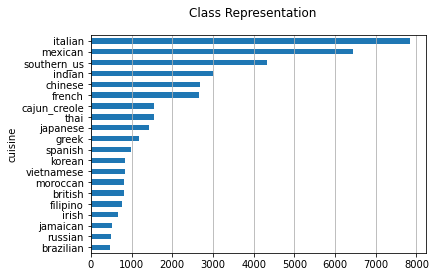

In [ ]:
#Visualise the distribution of the classes

fig, ax = plt.subplots()
fig.suptitle("Class Representation", fontsize=12)
recipes['cuisine'].reset_index().groupby("cuisine").count().sort_values(by= 
        "index").plot(kind="barh", legend=False, 
         ax=ax).grid(axis='x')
plt.show()

#### Model Training


In [ ]:
#Train the cuisine classier
cuisine = LogisticRegression(solver='saga')

#cuisne type model
XC = recipes['ingredients_mod'] #features

#label encoding
labelencoderCuisine = LabelEncoder()
yc = recipes['cuisine']
yc = labelencoderCuisine.fit_transform(yc)

#split dataset into train and test
XC_train, XC_test, yc_train, yc_test = train_test_split(XC, yc, test_size = 0.2, random_state = 42)
XC_train.shape, XC_test.shape, yc.shape

#train the model
cuisine = Pipeline([('tfidf', tfidf), ('cuisine', cuisine)])
cuisine.fit(XC_train, yc_train)
filename = 'cuisine_model.sav' #save model
pickle. dump(cuisine, open(filename, 'wb'))

In [ ]:
#Check the performance of the model
yc_pred = cuisine.predict(XC_test)
print(classification_report(yc_test, yc_pred))

              precision    recall  f1-score   support

           0       0.78      0.51      0.62        84
           1       0.66      0.35      0.46       157
           2       0.81      0.66      0.73       328
           3       0.76      0.86      0.81       510
           4       0.72      0.52      0.60       136
           5       0.61      0.65      0.63       550
           6       0.78      0.67      0.72       249
           7       0.87      0.90      0.89       602
           8       0.64      0.40      0.49       151
           9       0.79      0.91      0.84      1567
          10       0.92      0.59      0.72        91
          11       0.82      0.71      0.76       284
          12       0.87      0.74      0.80       166
          13       0.90      0.93      0.92      1336
          14       0.86      0.75      0.80       166
          15       0.56      0.39      0.46        89
          16       0.67      0.79      0.72       848
          17       0.67    

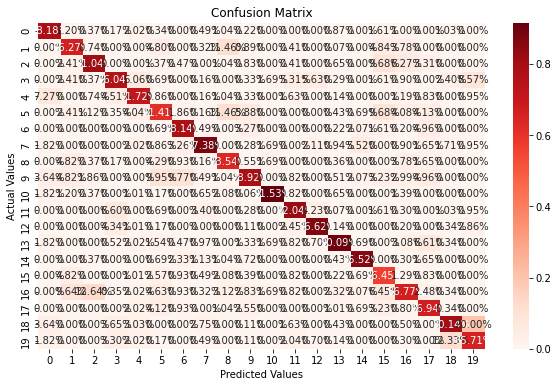

In [ ]:
#Plotting the confusion matrix
cm_cuisine = confusion_matrix(yc_test, yc_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm_cuisine)

plt.figure(figsize=(10,6))
sns.heatmap(cm_df/np.sum(cm_df), annot=True, cmap='Reds', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## **3) Diet Type**

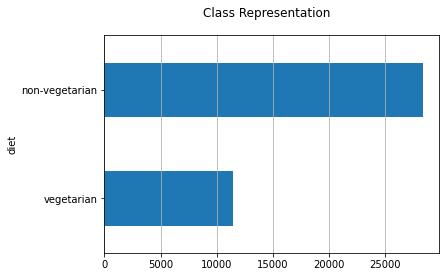

In [ ]:
#Visulaise distribution of classes
fig, ax = plt.subplots()
fig.suptitle("Class Representation", fontsize=12)
recipes['diet'].reset_index().groupby("diet").count().sort_values(by= 
        "index").plot(kind="barh", legend=False, 
         ax=ax).grid(axis='x')
plt.show()

#### Model Training

In [ ]:
#Train the diet type classifer
diet = LogisticRegression(solver='saga')

#Select features and labels
Xd = recipes['ingredients_mod'] #features

#encode labels
labelencoderD = LabelEncoder()
yd = labelencoderD.fit_transform(recipes['diet'])

#Split data into test and train
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size = 0.2, random_state = 42)

#Train the model
diet = Pipeline([('tfidf', tfidf), ('diet', diet)])
diet.fit(Xd_train, yd_train)
filename = 'diet_model.sav' #save model
pickle. dump(diet, open(filename, 'wb'))

In [ ]:
#Check model performance
yd_pred = diet.predict(Xd_test)
print(classification_report(yd_test, yd_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5668
           1       0.98      1.00      0.99      2287

    accuracy                           0.99      7955
   macro avg       0.99      0.99      0.99      7955
weighted avg       0.99      0.99      0.99      7955



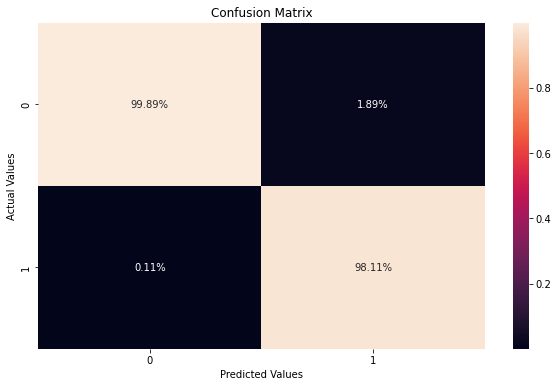

In [ ]:
#Plotting the confusion matrix
cm_diet = confusion_matrix(yd_test, yd_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df2 = pd.DataFrame(cm_diet)
#
plt.figure(figsize=(10,6))
sns.heatmap(cm_df2/np.sum(cm_df2), annot=True, fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## **4) Semantic Search Model**

In order to include some flexibility in matching the categories extracted from the user input to the categories in the yelp dataset, a semantic search is needed. This gensim model calculates a similarity matrix between the input categories and dataset and filters by a similarity score. The businesses selected here will be used for downstream semantic analysis of reviews.

In [ ]:
#create a column for cleaned and tokenised categories
resto['categories_mod'] = resto.categories.apply(text_data_cleaning)
resto=resto.reset_index() #index has to be reset 
resto.head(1)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurant,categories_mod
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True,"[restaurants, food, bubble, tea, coffee, tea, ..."


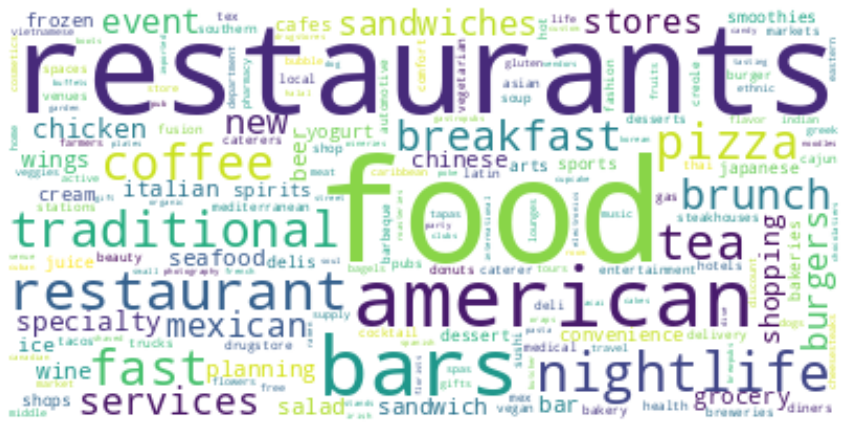

In [ ]:
#Checking the most common words in our data
from wordcloud import WordCloud

series = pd.Series(np.concatenate(resto['categories_mod'])).value_counts()[:]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)
resto['categories_mod'].head()
plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Topic modelling with Latent Semantic Indexing and TF-IDF 

In [ ]:
#create corpus
from gensim import corpora
res = resto['categories_mod']
dictionary = corpora.Dictionary(res)
dictionary.save('./categories.dict')  # store the dictionary, for future reference

In [ ]:
#create Bag-Of-Words
cat_corpus = [dictionary.doc2bow(text) for text in res]

#check out some words frequencies
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in cat_corpus[0:3]] #limit number to print
print(word_frequencies)

[[('bakery', 1), ('bubble', 1), ('coffee', 1), ('food', 1), ('restaurants', 1), ('tea', 2)], [('food', 1), ('breweries', 1), ('brewpubs', 1)], [('food', 2), ('restaurants', 1), ('burger', 1), ('cream', 1), ('fast', 1), ('frozen', 1), ('ice', 1), ('sandwiches', 1), ('yogurt', 1)]]


In [ ]:
corpora.MmCorpus.serialize('./categories.mm', cat_corpus)  # store corpus for use in foodie-app

#### Model Training

In [ ]:
#Train tfdif and lsi model for semantic search
import gensim

#Tf-idf model
tfidf_model = gensim.models.TfidfModel(cat_corpus, id2word=dictionary)
filename = 'tfidf_model.sav'
pickle. dump(tfidf_model, open(filename, 'wb'))

#Lsi model
lsi_model = gensim.models.LsiModel(tfidf_model[cat_corpus], id2word=dictionary)
filename = 'lsi_model.sav'
pickle. dump(lsi_model, open(filename, 'wb'))

#store the corpus for use in foodie-app
gensim.corpora.MmCorpus.serialize('tfidf_model_mm', tfidf_model[cat_corpus]) #save corpus
gensim.corpora.MmCorpus.serialize('lsi_model_mm',lsi_model[tfidf_model[cat_corpus]]) #save corpus

In [ ]:
#load indexed corpus
tfidf_corpus = gensim.corpora.MmCorpus('tfidf_model_mm')
lsi_corpus = gensim.corpora.MmCorpus('lsi_model_mm')

## <font color='red'>**Processing User Input**</font>

In [ ]:
###### How models are loaded in the backend of the foodie-app  #####
################################################################
#Load saved models 
course_model= pickle.load(open('/work/Foodie data/Basic_classification_models/meal_model.sav', 'rb'))
diet_model= pickle.load(open('/work/Foodie data/Basic_classification_models/diet_model.sav', 'rb'))
cuisine_model= pickle.load(open('/work/Foodie data/Basic_classification_models/cuisine_model.sav', 'rb'))
lsi_model =  pickle.load(open('/work/Foodie data/SemanticSearch/lsi_model.sav', 'rb'))
tfidf_model=  pickle.load(open('/work/Foodie data/SemanticSearch/tfidf_model.sav', 'rb'))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.1 when using version 1.0.2. This might lead to b

In [ ]:
# Run label encoders 
#load files for encoding
meals= pd.read_csv("/work/Foodie data/tokens/Meals_token.csv")
recipe= pd.read_csv("/work/Foodie data/tokens/Recipe_token.csv")
#run encoders
## creating mapping from unique label texts to unique integers
labelencoderCourse = LabelEncoder()
labelencoderCourse.fit_transform(meals['Food_Category'])
labelencoderDiet = LabelEncoder()
labelencoderDiet.fit_transform(recipe['diet'])
labelencoderCuisine = LabelEncoder()
labelencoderCuisine.fit_transform(recipe['cuisine'])

array([ 6, 16,  4, ...,  8,  3, 13])

In [ ]:
#user input simulation
inputs= []
inp =['I want to eat spicy potatoes of some kind. Maybe fries.']
inpt = text_data_cleaning(' '.join(inp)) #tokenise input

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
#expand vocubulary for input
import nltk
from nltk.corpus import wordnet

inputs=[]
for i in inpt:
    for synset in wordnet.synsets(i):
        for lem in synset.lemmas():
            inputs.append(lem.name()) 

input_test= [','.join(inputs)]
print(input_test)

['privation,want,deprivation,neediness,lack,deficiency,want,need,want,wish,wishing,want,desire,want,want,need,require,want,want,want,eat,eat,feed,eat,eat,eat_on,consume,eat_up,use_up,eat,deplete,exhaust,run_through,wipe_out,corrode,eat,rust,piquant,savory,savoury,spicy,zesty,hot,spicy,blue,gamy,gamey,juicy,naughty,racy,risque,spicy,potato,white_potato,Irish_potato,murphy,spud,tater,potato,white_potato,white_potato_vine,Solanum_tuberosum,kind,sort,form,variety,kind,kind,genial,kind,tolerant,possibly,perchance,perhaps,maybe,mayhap,peradventure,Fry,Roger_Fry,Roger_Eliot_Fry,Fry,Christopher_Fry,child,kid,youngster,minor,shaver,nipper,small_fry,tiddler,tike,tyke,fry,nestling,fry,fry,electrocute,fry']


In [ ]:
#run food_type classifier models on the user input
predm=course_model.predict(input_test) #classifies course or meal type
predd=diet_model.predict(input_test) #classifies diet type
predc=cuisine_model.predict(input_test) #classifies cuisine type

#labels must be inverse_transformed to words for matching to our restaurant database
categories = [' '.join(labelencoderCourse.inverse_transform(predm)), ''.join(labelencoderDiet.inverse_transform(predd)), ''.join(labelencoderCuisine.inverse_transform(predc))] 
print(categories) #these categories will be used downstream to search for restaurants using semantic search

['appetizer', 'vegetarian', 'italian']


## **Match Categories From User Input to Data**

In [ ]:
### Load saved corpus and dictionaries for backend use
tfidf_corpus = gensim.corpora.MmCorpus('tfidf_model_mm')
lsi_corpus = gensim.corpora.MmCorpus('lsi_model_mm')
dictionary = corpora.Dictionary.load('../path/recipe.dict')

In [ ]:
#generate a similarity matrix between our query and dataset corpus
from gensim.similarities import MatrixSimilarity
business_index = MatrixSimilarity(lsi_corpus, num_features = lsi_corpus.num_terms)

In [ ]:
from operator import itemgetter
tokenizer = text_data_cleaning
def search_similar(search_term):
    '''
    performs semantic search and similarity on a series of documents
    input: search_term is a document or series of documents
    returns: dataframe of most similar matches in descending order
    '''

    query_bow = dictionary.doc2bow(tokenizer(search_term))
    query_tfidf = tfidf_model[query_bow]
    query_lsi = lsi_model[query_tfidf]

    business_index.num_best = 50 #get the 50 most similar categories to our query

    business_list = business_index[query_lsi]

    business_list.sort(key=itemgetter(1), reverse=True)
    business_names = []

    for j, business in enumerate(business_list):

        business_names.append (
            {
                'Relevance': round((business[1] * 100),2),
                'name': resto['name'][business[0]],
                'business_id': resto['business_id'][business[0]],
                'categories': resto['categories_mod'][business[0]]
            }

        )
        if j == (business_index.num_best-1):
            break

    return pd.DataFrame(business_names, columns=['Relevance', 'name', 'business_id','categories'])

In [ ]:
#returns the categories from dataset that are related to categories from the user_input
search_similar(' '.join(categories))

,Relevance,name,business_id,categories
0,91.26,OPPI’Z Bistro And Natural Pizza,f7S0WFDy_J1TGahYhnoMLA,"[pizza, restaurants, italian, vegetarian]"
1,80.00,The QUICK FIXX,LtLbT776NOAjva1ttA2h3w,"[restaurants, pizza, vegetarian, salad, italian]"
2,76.37,Hip City Veg,7AV88DN083bPNmNue2my4Q,"[vegetarian, restaurant]"
3,74.74,Ground Foods Cafe,4PXVOfKw7kzKq3mS4DGwYg,"[vegetarian, vegan, italian, restaurants]"
4,73.75,Flying Pie Pizzaria,rEyTFs9o-xdXR-DMCLBiyg,"[restaurants, pizza, vegetarian]"
5,70.75,PLNT Burger,OT9SZuEFV-7lVMCcsZmb6Q,"[restaurants, burgers, vegetarian]"
6,70.75,Fat Mo's,Q5gW8CA-IKGeb_hFjzJGKQ,"[vegetarian, restaurants, burgers]"
7,70.65,Fieni's Ristorante,UPP2p7oGUrOfZ919RZqVIQ,"[restaurant, vegetarian, italian, seafood, foo..."
8,70.59,La Indita,dHpHptXgn1gpuxr_4DrMYQ,"[mexican, restaurants, vegetarian]"
9,69.99,Romaine's,SHk_eYKzIOPvgwvTThtXiQ,"[american, traditional, vegetarian, restaurants]"


As you can see from the final output of the model, the categories in the dataset are very similar. What's more some restaurants serve different types of food and may get matched more often than others. A more comprehensive classification would be needed to combat this.



---



<center><img src="https://www.printweek.com/media/169013/customerfeedback-pic.jpg?anchor=center&mode=crop&width=960&height=640&rnd=132179756770000000" width=600/></center>


# <font color='red'>**Sentiment Analyses model**</font>

This is the second "bloc" of our application. Here we trained a sentiment analyses model to asses each review. We could have just use the star rating, but we know that stars are not always true represention of the reviewer sentiment, as much as we know that the review on its own is not always enough to assess the quality of a restaurant.  

Most of the dataset available online only had 2 (or 5) sentiment such as positive/negative or like/dislike (or 5 stars) as the response variable. Hence we decided to create our own sentiment score based on 3 criteria:


*   Polarity of the review
*   Proportion of positive to negative words as a function of the total number of words
*   the star rating of that reviewer 

## **1) Create a training dataset and sentiment score**

**1.1. Extract a trained balanced subset**

Here we are creating the trained data and only selected the reviews that are in english.
We choose 5000 per star categories but with more time we could try with a larger dataset and see if it could improve the model accuracy



In [ ]:
# we decided here to take 5000 reviews in each star category to have a balance training set
train_df_all = reviews.groupby('stars').apply(lambda x: x.sample(5000))

In [ ]:
# Remove the reviews that aren't in english
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

def detect_language(text):
  doc = nlp(text)
  lang = doc._.language
  return list(lang.values())[0]

rev_to_remove=[]
for i,text in enumerate(train_df_all['text']):
  lan = detect_language(text)
  if lan != 'en':
    #print(lan)
    rev_to_remove.append(train_df_all.review_id.iloc[i])


train_df = train_df_all[~train_df_all['review_id'].isin(rev_to_remove)]
train_df.shape

(24746, 9)

In [ ]:
train_df.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool
0,--9e1ONYQuAa-CB_Rrw7Tw,HzB-6zA84zFePbzif_5D3g,uqPNpQ6LdHTtG_TnB7x4qA,2,2011-11-07,Over-rated!!!!!!!!! My steak was overly season...,0,0,0
1,--9e1ONYQuAa-CB_Rrw7Tw,c9lAv_pZYK6r1umrzAhnVA,3RGKgFproU4CflJVkAZw4w,2,2017-03-27,Rib eye steak for $51 should be pretty darn go...,1,0,1
2,--9e1ONYQuAa-CB_Rrw7Tw,A_erX_KsIdXA7P9upGlnFg,bWJWcQyDKtFSvsTW2tR3hw,3,2016-06-02,Good but not great for a high end steakhouse.\...,2,1,1
3,--9e1ONYQuAa-CB_Rrw7Tw,tsxxhdbtjme27b5zmdnmGQ,55fW1D1K79xLH2AKPWVVWw,3,2011-07-06,Of the half dozen or so high-end steakhouses I...,0,0,1
4,--9e1ONYQuAa-CB_Rrw7Tw,7fYoPiMa20VwN3mNAa_KMw,VqnKOb7vZU11BBmx7mUltQ,3,2017-02-25,"Steak was very tough. Surprising for $55.00, I...",0,0,0


**1.2. Stemming and Lemmatization of the reviews**

NLP and ML in general require some pre-processing steps of text to improve performances. Here we first clean the reviews by removing capital letters, stop words, and then we used 2 technics that are **stemming** and **lemmatization**. They both reduce the words to their root forms, however as described in the example below lemmatization always return a meaningfull words while steming does not.

<img src=https://miro.medium.com/max/1400/1*ES5bt7IoInIq2YioQp2zcQ.png width="500"/>

In [ ]:
import textblob
from textblob import Word
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# create "cleaned" reviews with only lowercase and without punctuations
lowercase = train_df['text'].apply(lambda x: ' '.join(word.lower() for word in str(x).split()))
train_df['cleaned'] = lowercase.str.replace('[^\w\s]', '') # new col

Reviews_noStopWords = []

for i in range(len(train_df)):
    review = str(train_df['cleaned'][i])
    review = review
    review = review.lower()
    
    stop_words = set(stopwords.words('english'))  # remove stop words
    word_tokens = word_tokenize(review)           # tokenised
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    
    Reviews_noStopWords.append(filtered_sentence)

train_df['No_Stop_Words:Tokens'] = Reviews_noStopWords
print(train_df['No_Stop_Words:Tokens'][0:3])


# make "sentences" using the tokens from above (no stop words, etc)
train_df['No_Stop_Words:Sentence'] = Reviews_noStopWords
for i in range(len(train_df)): 
    text_list = train_df['No_Stop_Words:Tokens'][i]
    blank = ''
    for word in text_list:
        blank = blank +' '+ word
    train_df['No_Stop_Words:Sentence'][i] = blank
print(train_df['No_Stop_Words:Sentence'][0:3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


0    [overrated, steak, overly, seasoned, way, salt...
1    [rib, eye, steak, 51, pretty, darn, good, got,...
2    [good, great, high, end, steakhouse, atmospher...
Name: No_Stop_Words:Tokens, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0     overrated steak overly seasoned way salty lik...
1     rib eye steak 51 pretty darn good got tender ...
2     good great high end steakhouse atmosphere b n...
Name: No_Stop_Words:Sentence, dtype: object


In [ ]:
# Lemmatization
train_df['lemmatized'] = train_df['No_Stop_Words:Sentence'].apply(lambda x: ' '.join(Word(word).lemmatize() for word in x.split()))
print(train_df['lemmatized'][0:3])

0    overrated steak overly seasoned way salty liki...
1    rib eye steak 51 pretty darn good got tender f...
2    good great high end steakhouse atmosphere b ni...
Name: lemmatized, dtype: object


In [ ]:
# Stemming the reviews (on the lemmatised col)
stemmed_list = []
snowBallStemmer = SnowballStemmer("english")

for i in range(len(train_df)):
    sentence = train_df['lemmatized'][i]
    wordList = nltk.word_tokenize(sentence)
    stemWords = [snowBallStemmer.stem(word) for word in wordList]
    
    stemmed = ' '.join(stemWords)
    stemmed_list.append(stemmed)

train_df['Stemmed'] = stemmed_list

In [ ]:
# Create token of for the stemmed sentence

def word_extraction(sentence):   
    words = re.sub("[^\w]", " ",  sentence).split()    
    cleaned_text = [w.lower() for w in words]    
    return cleaned_text

stemmed_tokens_list = []
for i in range(len(train_df)):
    stemmed = train_df['Stemmed'][i]
    tokens = word_extraction(stemmed)
    stemmed_tokens_list.append(tokens)

train_df['Stemmed_tokens'] = stemmed_tokens_list
print(train_df['Stemmed_tokens'][0:3])

0    [overr, steak, over, season, way, salti, like,...
1    [rib, eye, steak, 51, pretti, darn, good, got,...
2    [good, great, high, end, steakhous, atmospher,...
Name: Stemmed_tokens, dtype: object


**1.3. Calculate polarity and subjectivity**

We used the sentiment function of textblob which returns two properties: polarity and subjectivity, although here we will only use the polarity. 

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. 

In [ ]:
##Using TextBlob create columns for the polarity and subjectivity of the review_text
from textblob import TextBlob
train_df['polarity'] = train_df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[0])
train_df['subjectivity'] = train_df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[1])

**1.4. Calculate an index based on the proportion of positive and negative words**

This technique is another way of looking at the quality of a sentiment. It is the numner of positive words - number of negative words, the whole thing divided bu


In [ ]:
#Load positive and negative lexicons
file1 = open(r"/content/drive/MyDrive/DSI module3/Data/Positve_lexicon.txt", "r") #change directory
content1 = file1.read()
pos_lex = content1.splitlines()
pos_lex_stem = [snowBallStemmer.stem(word) for word in pos_lex] # to check when/if we need stemmed

file2 = open(r"/content/drive/MyDrive/DSI module3/Data/Negative_lexicon.txt", "r") #change directory
content2 = file2.read()
neg_lex = content2.splitlines()
neg_lex_stem = [snowBallStemmer.stem(word) for word in neg_lex] # to check when/if we need stemmed

In [ ]:
#Create positive and negative words count
pos_count = []
neg_count = []
prop_pos_neg = []

for i in range(len(train_df)):
    count_pos = 0
    count_neg = 0
    tokens = train_df['Stemmed_tokens'][i]
    for word in tokens:
      if word in pos_lex:  #if stemmed word - should use pos_lex_stem
          count_pos += 1
      elif word in neg_lex:   #if stemmed word - should use neg_lex_stem
          count_neg += 1
    pos_neg = (count_pos - count_neg)/len(tokens)  

    pos_count.append(count_pos)
    neg_count.append(count_neg)
    prop_pos_neg.append(pos_neg)
    
train_df['Pos_Word_Count'] = pos_count
train_df['Neg_Word_Count'] = neg_count
train_df['Prop_pos_neg_words'] = prop_pos_neg

**1.5. Combine the 3 criteria Polarity, star rating and proportion of positive/negative words**

In [ ]:
# we are first scaling the 3 indices
min_max_scaler = preprocessing.MinMaxScaler()
pol_scaled = min_max_scaler.fit_transform(np.array(train_df['polarity']).reshape(-1,1))
star_scaled = min_max_scaler.fit_transform(np.array(train_df['stars']).reshape(-1,1))
prop_pos_neg_scaled = min_max_scaler.fit_transform(np.array(train_df['Prop_pos_neg_words']).reshape(-1,1))

pol_scaled = [float(i) for i in pol_scaled]
star_scaled = [float(i) for i in star_scaled]
prop_pos_neg_scaled = [float(i) for i in prop_pos_neg_scaled]

# we have decided to average the 3 indeces here with same weight
train_df['sentiment_score'] = np.mean([pol_scaled,star_scaled,prop_pos_neg_scaled], axis=0)
 

**1.6. Classify into 20 categories from 1 (worst) to 20 (best)**

Because all the sentiment analyses models we found are classifiers, we transformed our sentiment score into 20 classes 

In [ ]:
# Classify the score into 20 catgories
sentiment_label = np.array(range(20))
levels = np.linspace(0,1,20)
  
sentiment = []
for i in range(len(train_df)):
    sentiment.append(np.where(train_df['sentiment_score'][i]>levels)[0][-1])  

train_df['sentiment'] = sentiment

In [ ]:
train_df.head(2)

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,cleaned,...,lemmatized,Stemmed,Stemmed_tokens,polarity,subjectivity,Pos_Word_Count,Neg_Word_Count,Prop_pos_neg_words,sentiment_score,sentiment
0,--9e1ONYQuAa-CB_Rrw7Tw,HzB-6zA84zFePbzif_5D3g,uqPNpQ6LdHTtG_TnB7x4qA,2,2011-11-07,Over-rated!!!!!!!!! My steak was overly season...,0,0,0,overrated my steak was overly seasoned it was ...,...,overrated steak overly seasoned way salty liki...,overr steak over season way salti like everyon...,"[overr, steak, over, season, way, salti, like,...",-0.066667,0.366667,3,1,0.117647,0.421895,8
1,--9e1ONYQuAa-CB_Rrw7Tw,c9lAv_pZYK6r1umrzAhnVA,3RGKgFproU4CflJVkAZw4w,2,2017-03-27,Rib eye steak for $51 should be pretty darn go...,1,0,1,rib eye steak for 51 should be pretty darn goo...,...,rib eye steak 51 pretty darn good got tender f...,rib eye steak 51 pretti darn good got tender f...,"[rib, eye, steak, 51, pretti, darn, good, got,...",0.076983,0.605409,12,9,0.018072,0.416333,7


**1.7. Few EDA checks on the training dataset and the sentiment score we have created**

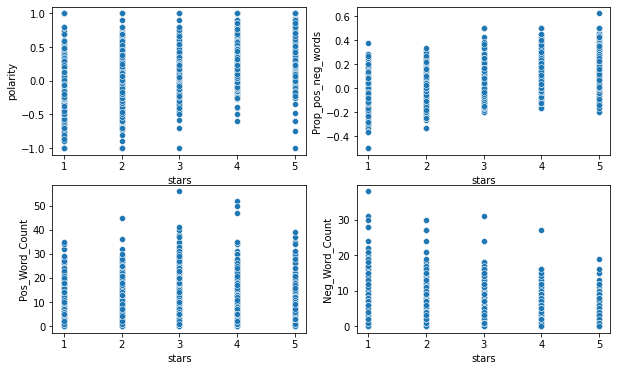

In [ ]:
# Description of the polarity and proportion of positive/negative words
# as a function to the star rating

fig, ax = plt.subplots(2,2, figsize=(10, 6))
sns.scatterplot(x='stars', y = 'polarity', data = train_df, ax=ax[0,0])
sns.scatterplot(x='stars', y = 'Prop_pos_neg_words', data = train_df, ax=ax[0,1])
sns.scatterplot(x='stars', y = 'Pos_Word_Count', data = train_df, ax=ax[1,0])
sns.scatterplot(x='stars', y = 'Neg_Word_Count', data = train_df, ax=ax[1,1])
plt.show()

We can see here that the polarity on its own seems to not vary that much between star rating while the proportion of positive to negative words seems to link slightly bettwe the star rating.
Although some of these aspects could be improved, we have decided to try with these indeces. We know that reviews and star rating are not always showing the same thing.

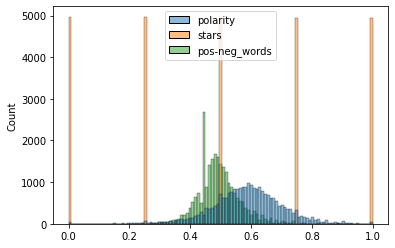

In [ ]:
# distribution of the 3 criteria we are using in the train_df after scaling
Scaled_scores = pd.DataFrame({'polarity':list(pol_scaled),
                              'stars': list(star_scaled),
                              'pos-neg_words':list(prop_pos_neg_scaled)})

sns.histplot(Scaled_scores)

plt.show()

We can see here that the dataset is not very well balanced with not many values at each extremes for the polarity and the proportion of positive/negative words. This potentially is a problem for the performance of our model. It is important to note however that this is a "natural" ocurrence in this type of dataset

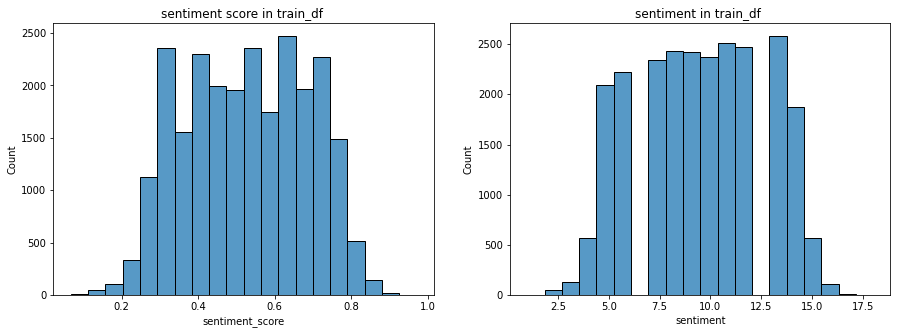

In [ ]:
# distribution of the sentiment score we calculated
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.histplot(x='sentiment_score',
              data=train_df,
              palette="RdYlBu",
              bins = 20, ax=ax[0]).set(title= 'sentiment score in train_df ')

sns.histplot(x='sentiment',
              data=train_df,
              palette="RdYlBu",
              bins = 20, ax=ax[1]).set(title= 'sentiment in train_df ')
plt.show()

Pooling the 3 indeces together and averaging them seems to somehow help a bit with the distribution of the sentiment score. We can see that the very "bad" and very "good" reviews are still not well represented.

We can also noticed that we could make some progress with the sentiment (values from 1 to 20) as we have some empty classes which aren't represented at all. We have tried less classes but we also had some classes with zero occurences.

Plost using the sentiment score


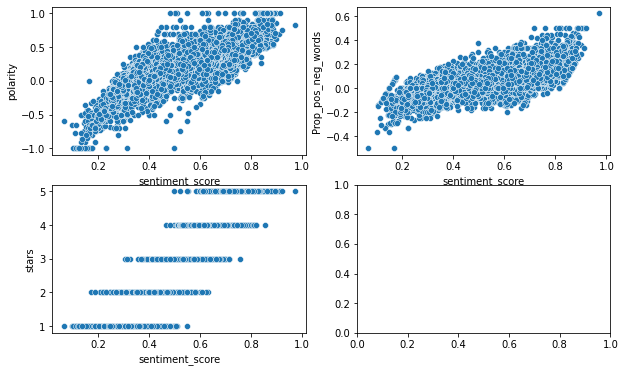

Plost using the sentiment values from 1 to 20


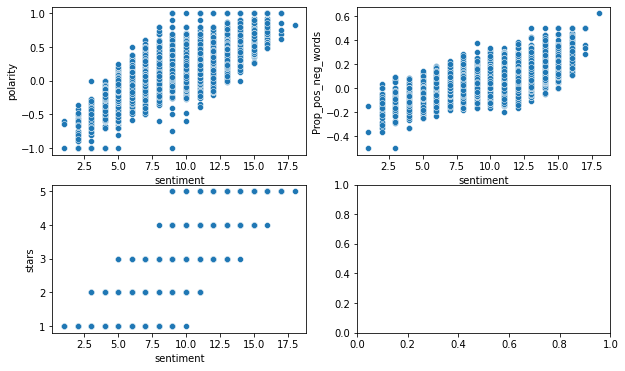

In [ ]:
print('Plost using the sentiment score')
fig, ax = plt.subplots(2,2, figsize=(10, 6))
sns.scatterplot(x='sentiment_score', y = 'polarity', data = train_df, ax=ax[0,0])
sns.scatterplot(x='sentiment_score', y = 'Prop_pos_neg_words', data = train_df, ax=ax[0,1])
sns.scatterplot(x='sentiment_score', y = 'stars', data = train_df, ax=ax[1,0])
plt.show()

print('Plost using the sentiment values from 1 to 20')
fig, ax = plt.subplots(2,2, figsize=(10, 6))
sns.scatterplot(x='sentiment', y = 'polarity', data = train_df, ax=ax[0,0])
sns.scatterplot(x='sentiment', y = 'Prop_pos_neg_words', data = train_df, ax=ax[0,1])
sns.scatterplot(x='sentiment', y = 'stars', data = train_df, ax=ax[1,0])
plt.show()

## **2) Training the sentiment model**

In [ ]:
# training target from unique label of the the sentiment column we created
y = train_df['sentiment']

# Logistic regression classifier

tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)

clf = LogisticRegression(solver='saga')
X = train_df['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

clf = Pipeline([('tfidf', tfidf), ('clf', clf)])
clf.fit(X_train, y_train)

#filename = 'sentiment_model_20Classes.sav'
#pickle.dump(clf, open(filename, 'wb'))

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x7eff298bcd40>)),
                ('clf', LogisticRegression(solver='saga'))])

In [ ]:
# Prediction of the X_test
results = clf.predict(X_test)

In [ ]:
# Check accuracy of the model 
test_accuracy = clf.score(X_test, y_test)
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.2971717171717172
F1 Score (macro):  0.19469806686414598
F1 Score (micro):  0.2971717171717172
F1 Score (weighted):  0.2875246473832666


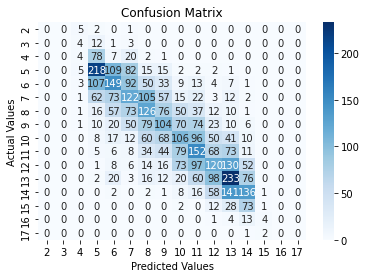

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, clf.predict(X_test), labels=None, sample_weight=None)

cm_df =  pd.DataFrame(cm, index= [i for i in np.sort(y_test.unique())],
                     columns= [i for i in np.sort(y_test.unique())])
sns.heatmap(cm_df, annot=True,cmap='Blues',fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

The accuracy of the model is not very high. With more time, we would have try to improve it and test other type of models. 
Nonetheless, it seems that the inaccuracy is +1 or -1 class around each class. Using 20 class is quite high for a sentiment classification model. Many model would only try to classify in 4 classes for instance (very good, good, bad, very bad).
The less class we are using and the higher the accuracy will be of course but as we want to improve the simple star rating, we belive that for this project, this is already an improvement. With more time, this can defintely be improved as well as trying other way of makeing a sentiment score. 

## **3) Model prediction on the yelp dataset**

The dataset is being stored in our database and will be updated once a week with new reviews. 

The model will be run once a week after the update and then the sentiment predicted. This simple batch processing allows us to save GPU and make the app faster.

In [ ]:
# Load the sentiment analysis model
sentiment_model = pickle.load(open('../input/sentimentmodelyelp/sentiment_model_20Classes.sav', 'rb'))

sentiment = []
def analyse_sentiment(text):
    token_text = text_data_cleaning(text)
    token_text2 = [' '.join(token_text)]
    sent = sentiment_model.predict(token_text2)
    return sent

sentiment = reviews['text'].apply(analyse_sentiment)
sentiment_cl = [i[0] for i in sentiment]
reviews['sentiment'] = sentiment_cl

We are now adding these different parameters to the files buisness and reviews

In [ ]:
# calculating the average star rating, sentiment, useful, funny and cool parameters
avgRest = reviews_NW.groupby(['business_id']).mean()

# adding the averages parameters to the reviews file
reviews_NW = reviews_NW.set_index('business_id')
reviews_final = reviews_NW.join(avgRest,rsuffix='_avg')

# adding the averages parameters to the buisness file
business_NW = business_NW.set_index('business_id')
business_final = business_NW.join(avgRest,rsuffix='_avg')

In [ ]:
reviews_final.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,sentiment,stars_avg,useful_avg,funny_avg,cool_avg,sentiment_avg
0,--0iUa4sNDFiZFrAdIWhZQ,o2QietGCr_V8HyrCkZB1uA,rspP9vDPeXMAfzC6Jj2vaw,4,4,0,0,Very good San Salvadorian place ! Authentic an...,2012-07-19 05:52:27,12,3.214286,1.785714,0.214286,0.285714,9.785714
1,--0iUa4sNDFiZFrAdIWhZQ,3BIp3g268nZ0HFhjHDr0Lw,Dr-atSrDQURhT9GiHn8D4Q,1,2,0,0,Didn't even get to try the papusas. Went in an...,2017-02-12 18:34:45,5,3.214286,1.785714,0.214286,0.285714,9.785714
2,--0iUa4sNDFiZFrAdIWhZQ,vmhIoWdIE8TCEewyJqOVeA,ojO2tgUhpJGUsU2mMBL24A,1,0,0,0,"If I could give 0 stars, I would. Ordered some...",2016-09-21 18:37:44,5,3.214286,1.785714,0.214286,0.285714,9.785714
3,--0iUa4sNDFiZFrAdIWhZQ,xlFTwZzBU1MttIiWZkL2eQ,6AjDticsrHFZoYoHEfDVWg,3,1,1,0,Dont be fooled by the 3 star rating. This pla...,2013-06-29 03:23:15,12,3.214286,1.785714,0.214286,0.285714,9.785714
4,--0iUa4sNDFiZFrAdIWhZQ,KBrJv6UNBRdBYHDqk5cU_w,tcTWVqBY2ayhj0EAJKM57w,3,0,0,0,"Building very clean, service slow but that's c...",2015-09-06 19:20:31,11,3.214286,1.785714,0.214286,0.285714,9.785714


In [ ]:
business_final.head()

,business_id,Unnamed: 0,name,address,city,state,postal_code,latitude,longitude,stars,...,attributes,categories,hours,restaurant,categories_mod,stars_avg,useful,funny,cool,sentiment
0,MTSW4McQd7CbVtyjqoe9mw,3,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,...,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True,"['restaurants', 'food', 'bubble', 'tea', 'coff...",4.057471,1.505747,0.540230,1.091954,11.022989
1,mWMc6_wTdE0EUBKIGXDVfA,4,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,...,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True,"['brewpubs', 'breweries', 'food']",4.692308,0.153846,0.000000,0.000000,12.076923
2,MUTTqe8uqyMdBl186RmNeA,15,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,...,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",True,"['sushi', 'bars', 'restaurants', 'japanese']",4.200000,1.304000,0.252000,0.656000,11.504000
3,ROeacJQwBeh05Rqg7F6TCg,19,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,...,"{'NoiseLevel': ""u'quiet'"", 'GoodForMeal': ""{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",True,"['korean', 'restaurant']",4.317308,0.798077,0.235577,0.423077,11.663462
4,kV_Q1oqis8Qli8dUoGpTyQ,33,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,PA,19003,40.006707,-75.289671,3.5,...,"{'RestaurantsGoodForGroups': 'True', 'WiFi': ""...","Pizza, Restaurants","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",True,"['pizza', 'restaurants']",3.482456,0.605263,0.298246,0.333333,10.157895


In [ ]:
# Save the files to be used in the app. These are the files that are updated each week
reviews_final.to_csv('reviews_NW_all_Scores_final.csv')
business_final.to_csv('business_NW_Scores_final.csv')

The output of this last cells is saved to the database and is queried everytime a user input is processed. When new reviews added the model is re-run and new sentiment score are calculated and stored. This process is repeated at pre=set intervals e.g weekly.

# Conclusion and Lesson's Learned
 > Natural language processing techniques can be used to make apps 'smarter'

 > Because computers do not process language like humans, it's difficult to train models to fully comprehend text input as you can see from our models.
 
 > Machine learning models can be used for NLP tasks with the addition of pre-processing. However, the choice of model used and type of data affects performance. Sklearn logistic regression models are basic and perfomed fairly well on simple classification but had more difficulties with sentiment analysis.
